# Диффузионные модели

## Домашнее задание [10 баллов]. Latent Diffusion

### Введение

На семинаре Вы познакомились с тем, как диффузионная модель реализуется на практике. А именно, мы рассмотрели базовую диффузионную модель DDPM из [(Ho et al., 2020)](https://arxiv.org/abs/2006.11239), в которой скрытые переменные есть те же изображений, но зашумленные. Такой подход на практике уже давно никто не использует, потому что он является очень вычислительно затратным. Вместо этого обычно рассматриваются скрытые переменные из латентного пространства какого-нибудь автоэнкодера - обычно, VQ-VAE [(Oord et al., 2017)](https://arxiv.org/abs/1711.00937), как в Stable Diffusion [(Rombach et al., 2021)](https://arxiv.org/abs/2112.10752). Подробнее про этот подход Вы можете прочесть в Модификациях диффузионных моделях, однако здесь мы приведем схематично его принцип работы. Итак, Latent Diffusion включает в себя следующие стадии:

1) Изображение пропускается через энкодер, благодаря чему получается его скрытое представление;

2) Уже в латентном пространстве обучается диффузионная модель для предсказания шума, добавляемого к скрытым переменным;

3) Полученное скрытое представление пропускается через декодер, вследствие чего создается новое изображение.

### Цель домашнего задания

1) Реализовать модель Latent Diffusion для безусловной генерации RGB изображений;

2) Обучить модель на [датасете](https://huggingface.co/datasets/nelorth/oxford-flowers) с изображениями цветов.

### Импортирование библиотек

In [90]:
from tqdm import tqdm
from typing import List, Tuple, Optional
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision.utils import make_grid

USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda' if USE_CUDA else 'cpu')
print(device)

cuda


### Датасет

Посмотрим на данные, с которыми нам предстоит иметь дело.  

In [ ]:
!pip install -q datasets

In [92]:
from datasets import load_dataset

dataset = load_dataset("nelorth/oxford-flowers", split='train')

Для ускорения процесса обучения мы отберем топ-3 самых часто встречающихся классов цветков.

In [93]:
from collections import Counter

k = 3
labels_selected = [x[0] for x in Counter(dataset['label']).most_common()[:k]]
print(f'Top-3 labels: {labels_selected}')
dataset = dataset.filter(lambda example: example['label'] in labels_selected)

Top-3 labels: [49, 77, 43]


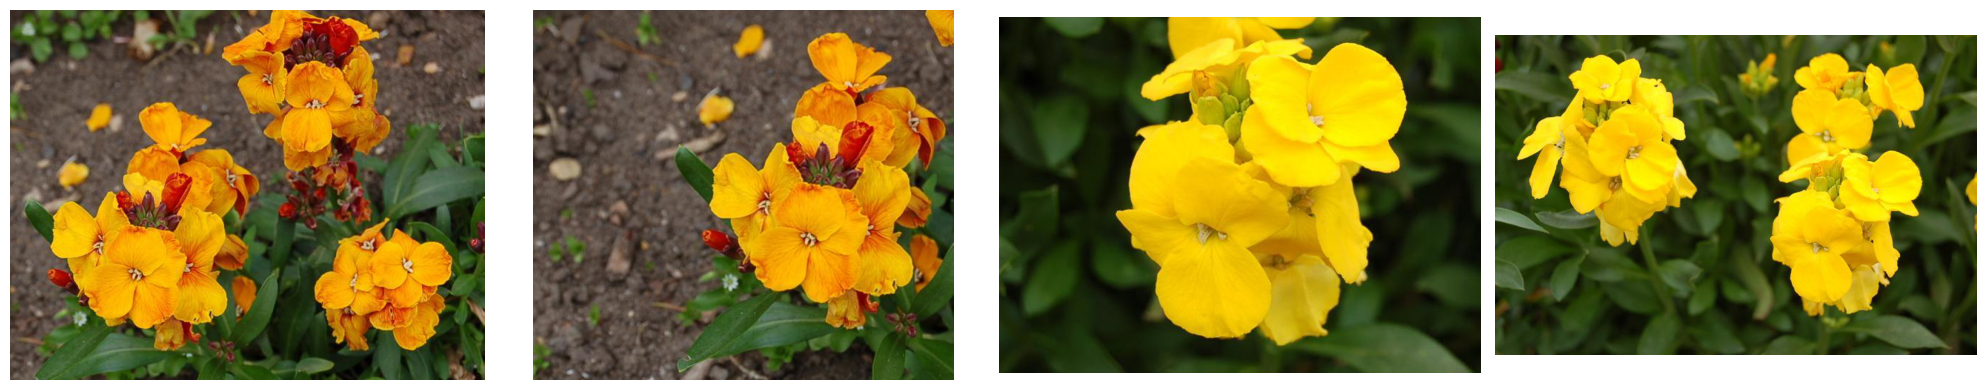

In [94]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

for i, image in enumerate(dataset[:4]['image']):
    axs[i].imshow(image)
    axs[i].set_axis_off()

plt.tight_layout()
plt.show()

Изображения все разного размера, поэтому Вам необходимо сначала предобработать их:
- `Resize` изменяет размер изображения до `(IMAGE_SIZE, IMAGE_SIZE)`;
- `RandomHorizontalFlip` аугментирует датасет с помощью случайных отражений изображений.

In [95]:
IMAGE_SIZE = 128

In [96]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]
)

Мы будем использовать метод `set_transform` из [🤗 Datasets](https://huggingface.co/docs/datasets), чтобы применять преобразования непосредственно во время обучения.

In [97]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

### Автокодировщик

Обучать автокодировщик для создания латентного представления изображений - очень сложная и долгая задача, требующая серьезных вычислительных мощностей. Поэтому мы предлагаем воспользоваться уже предобученной моделью [VQ-VAE](https://huggingface.co/docs/diffusers/api/models/autoencoderkl) от Stable Diffusion из библиотеки [🤗 Diffusers](https://huggingface.co/docs/diffusers).

In [98]:
!pip install -q -U diffusers
!pip install accelerate
!pip install --upgrade safetensors


In [99]:
from diffusers import AutoencoderKL

In [100]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae = vae.to(device)

### Диффузионная модель [9 баллов]

В отличие от семинара, где мы реализовывали модель U-Net для предсказания шума с нуля, здесь мы воспользуемся уже готовой [имплементацией Фила Ванга](https://github.com/lucidrains/denoising-diffusion-pytorch) и далее сконцентрируемся только на прямом и обратном диффузионных процессах.

Ниже Вы можете видеть вспомогательную функцию, которая преобразует число в тензор. Например, если необходимо создать тензор размера `broadcast_shape` из одного и того же числа, находящегося по индексу `index` в списке `array`. Посмотрите внимательно на этот код, Вам предстоит использовать его в большинстве методов.


In [101]:
def _extract_into_tensor(arr, indices, broadcast_shape):
    """
    Извлекает значения из одномерного torch tensor для батча индексов.
    :param arr: одномерный torch tensor.
    :param indices: тензор индексов, извлекаемых из arr.
    :param broadcast_shape: бОльший shape из K размерностей с размерностью батча,
                            равной длине indices.
    :return: тензор размерностей [batch_size, 1, ...], где shape имеет K размерностей.
    """
    assert len(arr.shape) == 1
    res = arr.to(device=indices.device)[indices].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)

#### Forward Diffusion [3 балла]

Давайте начнем с прямого диффузионного процесса. Вспомним основную теорию, которая пригодится в реализации диффузионной модели.

**Forward process** определяется как апостериорное распределение $q(\mathbf{x}_{1:T}|\mathbf{x}_0)$.

Это марковская цепь, которая последовательно добавляет гауссовский шум к исходному объекту $\mathbf{x}_0$.

На каждом шаге этого процесса гауссовский шум добавляется с разной магнитудой, которая определяется расписанием дисперсий $\{\beta_1, ... \beta_T\}$.
Если это расписание правильно выбрано, а $T$ стремится к бесконечности (или просто достаточно велико), мы будем сходиться к случайному шуму $\mathcal{N}(0, I)$.

Марковская цепь определяется как:
$$
 q(\mathbf{x}_t | \mathbf{x}_{t - 1}) := \mathcal{N}(\mathbf{x}_t | \sqrt{1 - \beta_t}\mathbf{x}_{t - 1}, \beta_tI), \ \ \ \ \ \ \ q(\mathbf{x}_{1:T}|\mathbf{x}_0) = \prod_{t = 1}^T q(\mathbf{x}_t | \mathbf{x}_{t - 1})
$$

Чтобы получить $\mathbf{x}_t$, нам необходимо вычислять $\mathbf{x}_1, ..., \mathbf{x}_{t - 1}$ итеративно.

К счастью, благодаря свойствам нормального распределения, мы можем сделать это более эффективно.

Обозначим
$\alpha_t = 1- \beta_t$ и $\bar{\alpha}_t= \prod_{s = 1}^t\alpha_s$.
Тогда
$$
q(\mathbf{x}_t | \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t|\sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1-\bar{\alpha}_t) \mathbf{I}).
\tag{1}
$$


Так мы можем получить очень полезное выражение
$$
    \mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1-\bar{\alpha}_t} \cdot \boldsymbol{\epsilon}. \tag{2}
$$

Создадим базовый класс для диффузии (мы будем использовать его для прямого и обратного процессов).

In [102]:
class BaseDiffusion:
    def __init__(self, num_timesteps: int):
        self.num_timesteps = num_timesteps
        self.betas = self._get_beta_schedule(num_timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=-1)

---

##### **Задание 1 [1 балл]**

При инициализации класса `BaseDiffusion` мы создаем расписание дисперсий `betas`. Вам необходимо написать метод `_get_beta_schedule`, который используется для этого. Он должен возвращать `np.ndarray` под названием `betas`, который будет иметь длину `num_diffusion_steps` и содержать значения `beta` от `beta_start` до `beta_end` в порядке возрастания. Для совместимости с `PyTorch` укажите при создании `dtype=np.float64`.

In [103]:
def _get_beta_schedule(self, num_diffusion_timesteps):
    assert num_diffusion_timesteps >= 20
    scale = 1000 / num_diffusion_timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    # ====
    # 1. Ваш код
    # Создайте np.ndarray, содержащий num_diffusion_steps значений beta
    # от beta_start до beta_end в порядке возрастания, укажите dtype=np.float64
    betas = np.linspace(beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64)
    # ====
    assert len(betas.shape) == 1, "betas must be 1-D"
    assert (betas > 0).all() and (betas <= 1).all()
    betas = torch.from_numpy(betas).double()
    return betas

BaseDiffusion._get_beta_schedule = _get_beta_schedule

basediff = BaseDiffusion(num_timesteps=20)
basediff.betas

tensor([0.0050, 0.0574, 0.1097, 0.1621, 0.2145, 0.2668, 0.3192, 0.3716, 0.4239,
        0.4763, 0.5287, 0.5811, 0.6334, 0.6858, 0.7382, 0.7905, 0.8429, 0.8953,
        0.9476, 1.0000], dtype=torch.float64)

---

Мы готовы определить прямой диффузионный процесс. У него будет два метода:
- чтобы получить среднее и дисперсию распределения $q(\mathbf{x}_t | \mathbf{x}_0)$,
- чтобы сгенерировать сэмплы из этого распределения.

In [104]:
class ForwardDiffusion(BaseDiffusion):
    pass

---

##### **Задание 2 [1 балл]**

От Вас требуется реализовать метод `get_mean_variance` класса `ForwardDiffusion`. Его суть заключается в том, чтобы по известному исходному `x0` и моменту времени `t` вычислить математическое ожидание и дисперсию распределения $q(\mathbf{x}_t | \mathbf{x}_0)$. Метод должен возвращать два `torch.tensor`, первый из которых, `mean`, содержит среднее значение искомого распределения, а второй, `variance`, содержит, соответственно, дисперсию. Используйте уравнение (1).

In [105]:
def get_mean_variance(self, x0, t):
    # ====
    # 2. Ваш код
    # Вычислите среднее и дисперсию распределения q(x_t | x_0) (используйте уравнение (1))
    # Подсказка: Используйте функцию `_extract_into_tensor`
    sqrt_alphas_cumprod = _extract_into_tensor(self.alphas_cumprod.sqrt(), t, x0.shape).to(x0.device)
    t = t.view(-1, 1).to(x0.device)

    mean = sqrt_alphas_cumprod * x0
    variance = (1 - _extract_into_tensor(self.alphas_cumprod, t, x0.shape).to(x0.device)) * torch.ones_like(x0).to(x0.device)
    
    
    # ====
    return mean, variance

ForwardDiffusion.get_mean_variance = get_mean_variance

---

---

##### **Задание 3 [1 балл]**



Вам необходимо реализовать метод `get_samples`. Ему на вход подаются исходный тензор `x0`, момент времени `t`, а также шум `noise`, то есть $\boldsymbol{\epsilon}$ в наших обозначениях. Метод должен генерировать сэмпл `samples` из распределения $q(\mathbf{x}_t | \mathbf{x}_0)$. Для этого нужно получить `mean` и `variance` с помощью метода `get_mean_variance`, а затем использовать их, а также шум `noise`, чтобы получить $\mathbf{x}_t$ из $\mathbf{x}_0$. Используйте уравнение (2).

In [106]:
def get_samples(self, x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0).to(x0.device)
    # ====
    # 3. Ваш код
    # Сгенерируйте сэмпл из распределения q(x_t | x_0) (используйте уравнение (2))
    mean, variance = self.get_mean_variance(x0, t)
    samples = mean + torch.sqrt(variance) * noise
    # ====
    return samples

ForwardDiffusion.get_samples = get_samples

---

In [107]:
# Тестирование Вашего кода
def test_forward_diffusion():
    fdiff = ForwardDiffusion(num_timesteps=100)
    SHAPE = [2, 20]
    x0 = torch.ones(SHAPE).to(device)
    t = torch.ones((2,)).long() * 5
    mean, variance = fdiff.get_mean_variance(x0=x0, t=t)
    assert list(mean.shape) == SHAPE
    assert list(variance.shape) == SHAPE
    assert np.allclose(mean.cpu().numpy(), np.ones(SHAPE) * 0.9820154)
    assert np.allclose(variance.cpu().numpy(), np.ones(SHAPE) * 0.03564582)

    xt = fdiff.get_samples(x0=x0, t=t)
    assert list(xt.shape) == SHAPE

    noise = torch.ones(SHAPE).to(device)
    xt = fdiff.get_samples(x0=x0, t=t, noise=noise)
    assert np.allclose(xt.cpu().numpy(), np.ones(SHAPE) * 1.1708164)
    print('Отлично, Вы справились!')

test_forward_diffusion()

Отлично, Вы справились!


#### Reverse Diffusion [4 балла]

**Reverse process** последовательно расшумляет чистый гауссовский шум $\mathcal{N}(\mathbf{0}, \mathbf{I})$, пока мы не получим объект из исходного распределения $q(\mathbf{x})$.

Это вероятностная модель с латентными переменными
$p(\mathbf{x}_0 | \boldsymbol{\theta}) := \int p(\mathbf{x}_{0:T} | \boldsymbol{\theta}) d\mathbf{x}_{1:T}$,
где
- скрытые переменные $\mathbf{z} = \{\mathbf{x}_1, ..., \mathbf{x}_T \}$ соответствуют зашумленным объектам,
- $\mathbf{x}_0$ есть объект из исходного распределения $q(\mathbf{x})$.


Совместное распределение $p(\mathbf{x}_{0:T} | \boldsymbol{\theta})$ называется обратным диффузионным процессом, который по существу есть Марковская цепь с гауссовскими распределениями $p(\mathbf{x}_{i-1}|\mathbf{x}_{i}, \boldsymbol{\theta})$:
$$
p(\mathbf{x}_{0:T} | \boldsymbol{\theta}) = p(\mathbf{x}_T | \boldsymbol{\theta}) \prod_{t = 1}^T p(\mathbf{x}_{t-1}|\mathbf{x}_t, \boldsymbol{\theta}), \quad p(\mathbf{x}_{T} | \boldsymbol{\theta}) = p(\mathbf{x}_{T}) = \mathcal{N}(\mathbf{x}_T | 0, \mathbf{I})
$$
$$
  p(\mathbf{x}_{t - 1}|\mathbf{x}_t, \boldsymbol{\theta}) = \mathcal{N}(\mathbf{x}_{t - 1}| \boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{x}_t, t), \boldsymbol{\sigma}^2_{\boldsymbol{\theta}}(\mathbf{x}_t, t)). \tag{3}
$$

Мы с Вами уже обсуждали, как получается нижняя вариационная оценка ELBO для такой модели:

$$
    \mathcal{L}(q, \boldsymbol{\theta}) =  \mathbb{E}_{q} \Bigl[\log p(\mathbf{x}_0 | \mathbf{x}_1, \boldsymbol{\theta}) - KL\bigl(q(\mathbf{x}_T | \mathbf{x}_0) || p(\mathbf{x}_T)\bigr)
    - \sum_{t=2}^T \underbrace{KL \bigl(q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) || p(\mathbf{x}_{t - 1} | \mathbf{x}_t, \boldsymbol{\theta} )\bigr)}_{\mathcal{L}_t} \Bigr].
$$

Здесь мы используем следующее распределение $q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_{t-1}; \boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0), \tilde{\beta}_t \mathbf{I}) $, где
$$
\boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0) = \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} \mathbf{x}_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t} \mathbf{x}_0
\tag{4}
$$
$$
\tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t
\tag{5}
$$

Эти страшные формулы на самом деле несложно вывести. Если интересно, больше деталей можете найти в оригинальной статье [Denoising Diffusion Probabilistic Models (Ho et al., 2020)](https://arxiv.org/abs/2006.11239).

Наша текущая цель состоит в определении параметров $\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{x}_t, t), \boldsymbol{\sigma}^2_{\boldsymbol{\theta}}(\mathbf{x}_t, t)$ обратного процесса.

##### Дисперсия
Наше первое предположение состоит в том, чтобы положить дисперсию равной $\boldsymbol{\sigma}^2_{\boldsymbol{\theta}}(\mathbf{x}_t, t) = \tilde{\beta}_t$. Это, на самом деле, очень естественное требование, поскольку нам хочется предсказывать в основном именно среднее значение.

##### Математическое ожидание
Здесь мы будем использовать выражение (2), чтобы получить $\mathbf{x}_0$ из $\mathbf{x}_t$:
$$
    \mathbf{x}_0 = \frac{\mathbf{x}_t - \sqrt{1 - \bar{\alpha}_{t}} \cdot \boldsymbol{\epsilon}}{\sqrt{\bar{\alpha}_{t}}}.
    \tag{6}
$$

Если мы подставим это выражение в формулу (4), то получим:
$$
    \boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \cdot \boldsymbol{\epsilon} \right).
$$

В целом, идея состоит в параметризации среднего значения нашей модели в таком же виде:
$$
    \boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{x}_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \cdot \boldsymbol{\epsilon}_{\boldsymbol{\theta}}(\mathbf{x}_t, t) \right).
$$


**Замечание**: наша модель предсказывает шум, который добавляется к $\mathbf{x}_0$, чтобы получить $\mathbf{x}_t$.

Перейдем к реализации обратного диффузионного процесса в коде. Для этого создадим класс `ReverseDiffusion`, унаследованный от `BaseDiffusion`.

In [108]:
class ReverseDiffusionTemplate(BaseDiffusion):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.alphas_cumprod_prev = torch.cat(
            [torch.tensor([1.0], device=self.betas.device), self.alphas_cumprod[:-1]], dim=0
        )

---

##### **Задание 4 [1 балл]**

От Вас требуется написать функцию `get_variances`, которая будет использоваться для того, чтобы определить дисперсии для обратного диффузионного процесса $q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0)$. Используйте уравнение (5)

In [109]:
def get_variances(self):
    # ====
    # 4. Ваш код
    # Вычислите дисперсию распределения q(x_{t-1} | x_t, x_0) (используйте уравнение (5))
    variance = (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod) * self.betas
    # ====
    # Первое значение ноль, но далее мы будем брать логарифм от выражения, поэтому заменим его на второе значение
    self.variance_clipped = torch.cat([variance[1:2], variance[1:]], dim=0)

ReverseDiffusionTemplate.get_variances = get_variances

---

---

##### **Задание 5 [1 балл]**

Подсчет дисперсии реализован. Теперь займемся математическим ожиданием. В следующей функции `get_coeffs` Вам необходимо вычислить коэффициенты, которые возникают перед $\mathbf{x}_t$ и $\mathbf{x}_0$ в формуле для среднего. Используйте уравнение (4).

In [110]:
def get_coeffs(self):
    # ====
    # 5. Ваш код
    # Вычислите коэффициенты перед слагаемыми в распределении q(x_{t-1} | x_t, x_0) (используйте уравнение (4))
    self.xt_coef = 1 / torch.sqrt(self.alphas)
    self.x0_coef = torch.sqrt(1 - self.alphas)
    # ====

ReverseDiffusionTemplate.get_coeffs = get_coeffs

---

In [111]:
class ReverseDiffusion(ReverseDiffusionTemplate):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.get_variances()
        self.get_coeffs()

---

##### **Задание 6 [1 балл]**

Коэффициенты перед $\mathbf{x}_t$ и $\mathbf{x}_0$ Вы уже подсчитали, но теперь нужно разобраться с самим $\mathbf{x}_0$. Далее Вам предлагается написать функцию `get_x0`, которой на вход подается зашумленное изображение `xt`, добавленный шум `eps`, а также момент времени `t`. Она должна возвращать `x0` - исходное изображение. Используйте уравнение (6).

In [ ]:
def get_x0(self, xt, eps, t):
    # ====
    # 6. Ваш код
    # Получите x_0 (используйте уравнение (6))
    device = xt.device

    t_expanded = t.unsqueeze(1)
    alphas_cumprod_t = _extract_into_tensor(self.alphas_cumprod, t_expanded, xt.shape)
    sqrt_alphas_cumprod = alphas_cumprod_t.sqrt()

    x0 = (xt - (1 - alphas_cumprod_t).sqrt() * eps) / sqrt_alphas_cumprod
    # ====
    return x0

ReverseDiffusion.get_x0 = get_x0

---

---

##### **Задание 7 [1 балл]**

Наконец, можно реализовать метод подсчета тензоров математического ожидания и дисперсии в обратном диффузионном процессе. Далее Вы можете наблюдать функцию `get_mean_variance_reverse`. На вход она получает то же, что и `get_x0`, то есть зашумленное изображение `xt`, добавленный шум `eps`, а также момент времени `t`. Возвращать должна два `torch.tensor` - `mean` и `variance`. Используйте уравнения (4) и (5).

In [ ]:
def get_mean_variance_reverse(self, xt, eps, t):
    # ====
    # 7. Ваш код
    # Получите среднее и дисперсию распределения q(x_{t-1} | x_t, x_0) (используйте уравнения (4) и (5))
    x0 = self.get_x0(xt, eps, t)

    alphas_cumprod_t = _extract_into_tensor(self.alphas_cumprod, t, xt.shape).to(xt.device)
    alphas_cumprod_prev = _extract_into_tensor(self.alphas_cumprod_prev, t, xt.shape).to(xt.device)
    beta_t = _extract_into_tensor(self.betas, t, xt.shape).to(xt.device)
    alpha_t = _extract_into_tensor(self.alphas, t, xt.shape).to(xt.device)

    mean_coef1 = torch.sqrt(alphas_cumprod_prev) * beta_t / (1 - alphas_cumprod_t)
    mean_coef2 = torch.sqrt(alpha_t) * (1 - alphas_cumprod_prev) / (1 - alphas_cumprod_t)
    mean = mean_coef1 * x0 + mean_coef2 * xt

    variance = (1 - alphas_cumprod_prev) / (1 - alphas_cumprod_t) * beta_t
    return mean, variance

ReverseDiffusion.get_mean_variance = get_mean_variance_reverse

---

Просим Вас прочитать внимательно следующий код. Функция `get_samples` возрвращает сэмпл из распределения обратного диффузионного процесса, используя все вышеопределенные Вами функции.

In [ ]:
def get_samples(self, xt, eps, t):
    # Прочитайте этот код внимательно
    mean, variance = self.get_mean_variance(xt=xt, eps=eps, t=t)
    noise = torch.randn_like(xt, device=xt.device).to(xt.device)

    nonzero_mask = torch.ones_like(t).to(xt.device)
    nonzero_mask[t == 0] = 0
    nonzero_mask = _extract_into_tensor(
        nonzero_mask, torch.arange(nonzero_mask.shape[0]), xt.shape
    ).to(xt.device)
    nonzero_mask = nonzero_mask.to(xt.device)
    sample = mean + nonzero_mask * variance.sqrt() * noise
    return sample.float()

ReverseDiffusion.get_samples = get_samples

Далее протестируем весь написанный код, чтобы убедиться в правильности имплементации.

In [115]:
# Тестирование Вашего кода
def test_reverse_diffusion():
    rdiff = ReverseDiffusion(num_timesteps=100)
    SHAPE = [2, 20]
    xt = torch.ones(SHAPE).to(device)
    eps = torch.ones(SHAPE).to(device)
    t = torch.ones((2,)).long() * 5

    x0 = rdiff.get_x0(xt=xt, eps=eps, t=t)
    assert list(x0.shape) == SHAPE
    assert np.allclose(x0.cpu().numpy(), np.ones(SHAPE) * 0.8260552, atol=1e-1)

    mean, variance = rdiff.get_mean_variance(xt=xt, eps=eps, t=t)
    assert list(mean.shape) == SHAPE
    assert list(variance.shape) == SHAPE
    assert np.allclose(mean.cpu().numpy(), np.ones(SHAPE) * 0.9467155, atol=1e-1)
    assert np.allclose(variance.cpu().numpy(), np.ones(SHAPE) * 0.007709955, atol=1e-1)

    x = rdiff.get_samples(xt, eps, t)
    assert list(x.shape) == SHAPE
    print('Отлично, Вы справились!')


test_reverse_diffusion()

Отлично, Вы справились!


#### Модель предсказания шума

Нейронная сеть U-Net для предсказания шума, как было сказано, уже написана за Вас. Остается только импортировать ее.

In [116]:
!pip install -q -U denoising_diffusion_pytorch

In [117]:
from denoising_diffusion_pytorch import Unet

#### DDPM [2 балла]

Вернемся к ELBO. Основная ее часть это
$$
    \mathcal{L}_t = KL \bigl(q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) || p(\mathbf{x}_{t - 1} | \mathbf{x}_t, \boldsymbol{\theta} )\bigr).
$$

Как обсуждалось ранее, переходя к параметризации шума, можно получить следующее выражение:
$$
    \mathcal{L}_t = \mathbb{E}_{\boldsymbol{\epsilon}} \left[ \frac{\beta_t^2}{2 \tilde{\beta_t} \alpha_t (1 - \bar{\alpha}_t)} \| \boldsymbol{\epsilon} - \boldsymbol{\epsilon}_{\boldsymbol{\theta}}(\mathbf{x}_t, t) \|^2 \right].
$$

На практике этот лосс еще упрощается. А именно, мы опустим коэффиценты перед нормами и будем сэмплировать индекс $t$ на каждой итерации обучения.

Окончательно, мы будем обучать нашу модель со следующим лоссом:
$$
\text{loss} = \mathbb{E}_{\mathbf{x}_0, \boldsymbol{\epsilon}, t}\bigg[ \|\boldsymbol{\epsilon} - \boldsymbol{\epsilon}_{\boldsymbol{\theta}}(\mathbf{x}_t, t)\|^2\bigg],
$$
где $\mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \boldsymbol{\epsilon}$.

Следующий класс имплементирует два метода:
- `train_loss` - чтобы вычислять лосс на итерации обучения;
- `sample` - чтобы сэмплировать из финальной модели.

In [118]:
class DDPM(nn.Module):
    def __init__(self, num_timesteps: int, model: nn.Module):
        super().__init__()

        self.num_timesteps = num_timesteps

        self.forward_diffusion = ForwardDiffusion(num_timesteps=num_timesteps)
        self.reverse_diffusion = ReverseDiffusion(num_timesteps=num_timesteps)
        self.model = model
        self.shape = None

    @property
    def device(self):
        return next(self.parameters()).device

---

##### **Задание 8 [1 балл]**

От Вас требуется написать часть функции `sample`. На вход ей подается число сэмплов `num_samples`, которые будут сделаны из итоговой модели. Ваша часть состоит в том, чтобы получить $\boldsymbol{\epsilon}_{\boldsymbol{\theta}}(\mathbf{x}_t, t)$ с помощью модели `self.model` (в нашем случае это U-Net), а затем сделать очередной шаг обратного процесса, сгенерировав сэмпл из соответствующего распределения. В этом Вам должна помочь функция `get_samples` у `self.reverse_diffusion`.

In [119]:
def sample(self, num_samples):
    assert self.shape is not None
    x = torch.randn((num_samples, *self.shape), device=self.device, dtype=torch.float32)
    indices = list(range(self.num_timesteps))[::-1]

    for i in tqdm(indices):
        t = torch.tensor([i] * num_samples, device=x.device)
        with torch.no_grad():
            # ====
            # 8. Ваш код
            # 1) Получите epsilon из модели
            eps = self.model(x, t)
            # 2) Сгенерируйте сэмпл из обратной диффузии
            x = self.reverse_diffusion.get_samples(xt=x, eps=eps, t=t)
            # ====
    return x

DDPM.sample = sample

---

---

##### **Задание 9 [1 балл]**

Настал черед `train_loss` - функции, которая получает на вход исходное изображение `x0`, а возвращает `loss`, подсчитанный с помощью `F.mse_loss`. Вам необходимо с помощью `self.forward_diffusion` сгенерировать сэмплы `xt` (см. метод `get_samples`), а затем получить предсказание `eps` добавленного шума с помощью `self.model`.

In [120]:
def train_loss(self, x0):
    if self.shape is None:
        self.shape = list(x0.shape)[1:]
    t = torch.randint(0, self.num_timesteps, size=(x0.size(0),), device=x0.device)
    noise = torch.randn_like(x0).to(x0.device)

    # ====
    # 9. Ваш код
    # 1) Получите x_t
    xt = self.forward_diffusion.get_samples(x0=x0, t=t)
    # 2) Получите epsilon из модели
    eps = self.model(xt, t)
    # ====
    loss = F.mse_loss(eps, noise)
    return loss

DDPM.train_loss = train_loss

### Обучение [1 балл]

Сейчас мы готовы обучить нашу модель.

---

##### **Задание 10 [1 балл]**

В процессе обучения мы, как обсуждалось ранее, пропускаем через энкодер вариационного автокодировщика `vae` исходное изображение. Энкодер выдает нам распределение в скрытом пространстве `latent_dist`. Далее из этого распределения мы сэмплируем `z`. И вот этот `z` уже подается на вход DDPM, которая и возвращает нам loss. Вам нужно реализовать часть процесса обучения - функцию `get_latent`, которая реализует получение распределения в скрытом пространстве и сэмплирование.

In [121]:
def get_latent(vae, x):
    # ====
    # 10. Ваш код
    # 1) Получите распределение в латентном пространстве VQ-VAE, подав в него x
    latent_dist = vae.encode(x).latent_dist
    # 2) Сгенерируйте сэмпл z из этого распределения
    z = latent_dist.sample() * 0.18215
    return z

---

In [122]:
import torch.optim.lr_scheduler as lr_scheduler

def train_model(
    vae: AutoencoderKL,
    ddpm: DDPM,
    dataloader: data.DataLoader,
    lr: float,
    weight_decay: float,
    steps: int,
    use_cuda: bool,
    log_every: int = 500
):

    def _anneal_lr(step: int):
        frac_done = step / steps
        current_lr = lr * (1 - frac_done)
        for param_group in optimizer.param_groups:
            param_group["lr"] = current_lr

    if USE_CUDA:
        vae = vae.cuda()
        ddpm = ddpm.cuda()
        vae = vae.to(device)
        ddpm = ddpm.to(device)
    optimizer = torch.optim.AdamW(
        ddpm.model.parameters(), lr=lr, weight_decay=weight_decay
    )
    
    scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=steps, pct_start=0.1)
    
    step = 0
    curr_loss_gauss = 0.0
    curr_count = 0
    optimizer.zero_grad()
    data_iter = iter(dataloader)
    while step < steps:
        try:
            x = next(data_iter)['images'].to(device)
        except StopIteration:
            data_iter = iter(dataloader)
            x = next(data_iter)['images'].to(device)

        if USE_CUDA:
            x = x.cuda()

        z = get_latent(vae, x)

        loss = ddpm.train_loss(z)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(ddpm.model.parameters(), max_norm=1.0)

        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()

        curr_count += len(z)
        curr_loss_gauss += loss.item() * len(z)

        if (step + 1) % log_every == 0:
            gloss = np.around(curr_loss_gauss / curr_count, 4)
            print(f"Step {(step + 1)}/{steps} Loss: {gloss}")
            curr_count = 0
            curr_loss_gauss = 0.0

        step += 1

---

##### **Подбор параметров обучения**

Последнее, что Вы должны сделать в этом домашнем задании - поэкспериментировать с параметрами обучения получившейся нейронной сети. В качестве начального приближения можно использовать следующий набор:
- `BATCH_SIZE = 16`
- `LR = 1e-3`
- `WEIGHT_DECAY = 1e-5`
- `STEPS = 10000`

In [123]:
%%time

T = 1000
# ====
# Ваш код
# Подберите эти параметры
BATCH_SIZE = 16
LR = 1e-3
WEIGHT_DECAY = 1e-5
STEPS = 10000
# ====

dataloader = data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)
unet = Unet(dim=64,
            dim_mults=(1, 2, 4, 8),
            channels=vae.config.latent_channels)
ddpm = DDPM(num_timesteps=T, model=unet)

train_model(
    vae=vae,
    ddpm=ddpm,
    dataloader=dataloader,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    steps=STEPS,
    use_cuda=USE_CUDA,
    log_every=500
)

Step 500/10000 Loss: 1.0044
Step 1000/10000 Loss: 1.0005
Step 1500/10000 Loss: 0.9993
Step 2000/10000 Loss: 1.0002
Step 2500/10000 Loss: 1.0004
Step 3000/10000 Loss: 1.0002
Step 3500/10000 Loss: 1.0004
Step 4000/10000 Loss: 1.0005
Step 4500/10000 Loss: 1.0001
Step 5000/10000 Loss: 1.0005
Step 5500/10000 Loss: 0.9993
Step 6000/10000 Loss: 1.0005
Step 6500/10000 Loss: 1.0002
Step 7000/10000 Loss: 1.0002
Step 7500/10000 Loss: 0.9989
Step 8000/10000 Loss: 1.0001
Step 8500/10000 Loss: 0.9994
Step 9000/10000 Loss: 0.9997
Step 9500/10000 Loss: 1.0008
Step 10000/10000 Loss: 0.9993
CPU times: total: 1h 51min 11s
Wall time: 1h 45min 32s


---

Теперь можно посмотреть, какие изображения способна генерировать наша модель. Для этого необходимо создать несколько сэмплов в латентном пространстве с помощью написанной нами модели DDPM.

In [126]:
num_samples = 4
latent_samples = ddpm.sample(num_samples)
latent_samples.shape

100%|██████████| 1000/1000 [00:16<00:00, 59.66it/s]


torch.Size([4, 4, 16, 16])

Далее пропустим их через декодер нашего VQ-VAE.

In [127]:
samples = vae.decode(latent_samples).sample.detach()
samples.shape

torch.Size([4, 3, 128, 128])

Остается только вывести полученные изображения.

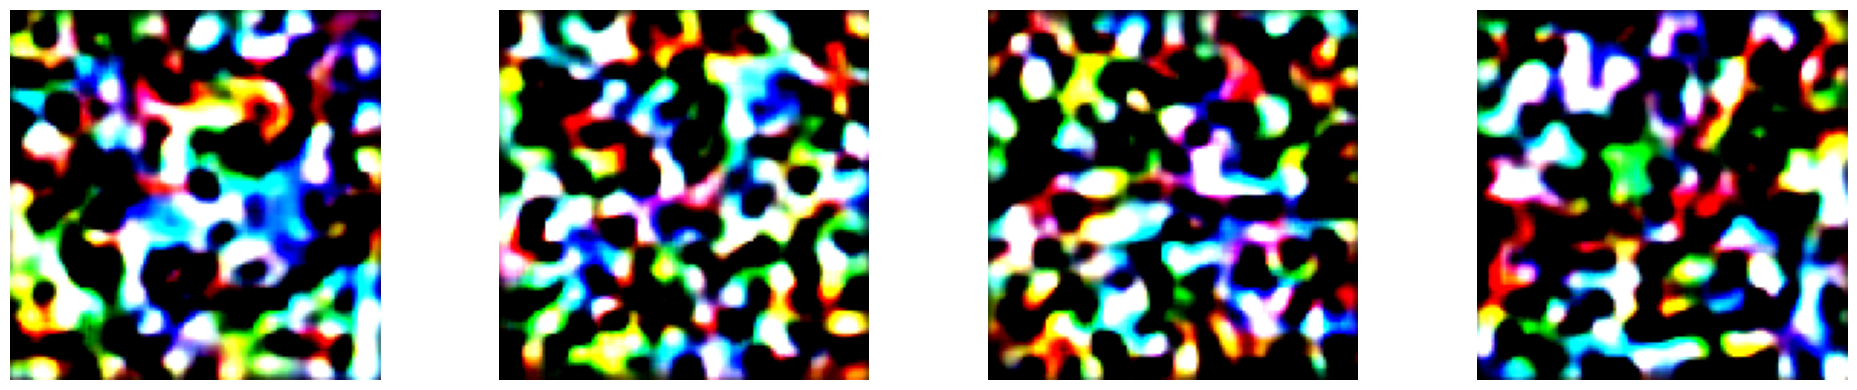

In [128]:
from PIL import Image

images = [np.uint8(sample.permute((1, 2, 0)).cpu().numpy().clip(0, 1) * 255) for sample in samples]
images = [Image.fromarray(image, mode='RGB') for image in images]

fig, axs = plt.subplots(1, 4, figsize=(20, 4))

for i, image in enumerate(images):
    axs[i].imshow(image)
    axs[i].set_axis_off()

plt.tight_layout()
plt.savefig("results.png", bbox_inches="tight")
plt.show()

Ниже Вы можете видеть изображения, которые получаются при обучении модели в течение ~2 часов на GPU T4.

<img src="https://drive.google.com/uc?id=16z0E10sIDPeT29vC3eW-8Q2jxYAqGmOL"/>